### Environmental condition bounds for load simulations

A 7-D sample space with 6 environmental variables and one operational (yaw misalignment)

- Wind speed: $u=$ truncated Weibull [4,25m/s] with $A = 11.28$ and $k = 2$ (IEC wind speed class I, [1]). 
- Turbulence $\sigma_u$: log-normally distributed, with distribution parameters conditional on $u$ (IEC turbulence clas B):
    - $\mu_{\sigma_u}|u = I_{ref}(0.75u + 3.8)$
    - $\sigma_{\sigma_u}|u = 1.4I_{ref}$
- Wind shear exponent $\alpha$: Normally distributed, with distribution parameters conditional on $u$ based on [2]:
    - $\mu_{\alpha} = 0.088(ln(u) - 1)$
    - $\sigma_{\alpha} = 1/u$
- Significant wave height $H_s$: Weibull-distributed, distribution parameters conditional on $u$:
    - $A = 1.8 + 0.1u$
    - $k = 2.0 + 0.135u$
- Wave peak period $T_p$: Lognormally distributed, distribution parameters conditional on $u$ and $H_s$:
    - $\mu_{T_p} = (4.883 + 2.68H_s^{0.529})(1 - 0.19u - (1.764 + 3.426H_s^{0.78}))/(1.764 + 3.426H_s^{0.78} ) )$
    - $\sigma_{T_p} = \mu_{T_p}( -1.7\cdot10^{-3} + 0.259e^{-0.113H_s})$
- Air density $\rho$: Normally distributed, with distribution parameters:
    - $\mu_{\rho} = 1.225kg/m^3$
    - $\sigma_{\rho} = 0.05kg/m^3$
- Yaw misalignment: Uniformly distributed:
    - Bounded between $\pm 15 ^{\circ}$    

For the turbulence spectral parameters, the standard values of the Mann model parameters are used ($L = 29.4m$, $\Gamma = 3.9$). 

#### References:
[1] IEC. International Standard IEC 61400-1: Wind Turbines—Part 1: Design Guidelines
[2] Dimitrov, N. K., Natarajan, A., & Kelly, M. C. (2015). Model of wind shear conditional on turbulence and its impact on wind turbine loads. Wind Energy, 18(11), 1917–1931. https://doi.org/10.1002/we.1797
[3] Johannessen, K., Meling, T. S., & Haver, S. (2001). Joint distribution for wind and waves in the Northern North Sea. Proceedings of the International Offshore and Polar Engineering Conference, 3, 19–28


### Load simulation setup
- IEC 15MW wind turbine with the DTU controller placed on a monopile. 
- One blade (blade 2) is 0.5% heavier than the other two blades, simulated through a lumped mass added at the center of gravity.
- One blade (blade 3) has a 0.5deg pitch offset, simulated through rotating the relative position of the blade in the model. 
- Total simulation duration is 700s. The usable time series length is 10 minutes (600s), while the first 100s are needed for initialization of the load simulation tool. 
- Six random turbulence seeds are generated at each of the DoE sample points

### Data formatting
- Sampling frequency: 50Hz. All signals are simulated with 50Hz frequency, apart from the turbulence boxes where due to size limitations the number of points in longitudinal direction is always equal to $2^{13} = 8192$. 
- Output format: 
    - csv files containing time series data for all channels, one file per 10min simulation
    - one text file with channel descriptions (name, location, data units)
    - one csv file with summary of all channel statistics (mean, max, min, std.dev., DEL) over all sample points
- Turbulence output:
    - Due to size limitations, it is not possible to include full-size turbulence boxes in the data package. Instead, a turbulence box generator script is provided that can re-generate exactly the same turbulence boxes as those used in the simulations. Example Python scripts are provided to generate and read turbulence files on-the-fly. 
    - Two options for taking the initiation period into account:
        1) Output consists of 700s load time series. The turbulence boxes generated also correspond to 700s. The users are responsible for cutting/ignoring the first 100s of the simulations
        2) Only the last 600s of the load time series are provided. An auxiliary Python script is provided that generates 700s turbulence boxes and discards the first 100s to provide a correct match with the load simulation time series

### Signals list 
- Wind speed in the rotor plane: five points in total:
    - Hub location
    - 2/3 of blade radius, azimuth 0, 90, 180, 270deg
- Rotor azimuth
- Rotor rotational speed
- Blade pitch angle (collective)
- Electrical power
- Generator torque
- Low-speed shaft torque and bending moments (3DOF) in the shaft (rotating) coordinate system
- Blade root bending moments and shear forces (6DOF), in rotating blade system coordinates (flapwise / edgewise)
- Blade 1/3 radial distance bending moments and shear forces (6DOF), in rotating blade system coordinates (flapwise / edgewise)
- Blade 2/3 radial distance bending moments and shear forces (6DOF), in rotating blade system coordinates (flapwise / edgewise)
- Blade tip deflection (3DOF), relative to non-rotating coordinate system
- Tower top accelerations (2DOF)
- Tower mid accelerations (2DOF) - at 50% distance between tower base and tower top
- Tower base accelerations (2DOF)
- Tower top bending moments and shear forces (6DOF)
- Tower mid bending moments and shear forces (6DOF)
- Tower base bending moments and shear forces (6DOF)
- Seabed shear forces and bending moments (6DOF)



.



.



.



.



.



.



.



.



.



.

In [1]:
import numpy as np
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import pandas as pd
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
# CREATE RANDOM SAMPLES
Nsamples = 1000

Ndimensions = 7

X0 = np.asarray(tfp.mcmc.sample_halton_sequence(Ndimensions,num_results = Nsamples,randomized = False))

C:\Users\nkdi\Anaconda3\envs\PythonEnvironment_2023\lib\site-packages\tensorflow_probability\python\__init__.py:70: UserWarning: TensorFloat-32 matmul/conv are enabled for NVIDIA Ampere+ GPUs. The resulting loss of precision may hinder MCMC convergence. To turn off, run `tf.config.experimental.enable_tensor_float_32_execution(False)`. For more detail, see https://github.com/tensorflow/community/pull/287.
  warnings.warn(


In [3]:
# HELPER FUNCTIONS
def UniformDist(Task,x,a = 0,b = 1):
    import numpy as np

    if Task == 0:
        y = np.ones(x.shape)/(b-a)
        y[(x < a) | (x > b)] = 0
    if Task == 1:
        y = (x - a)/(b - a)
        y[x < a] = 0
        y[x > b] = 1
    if Task == 2:
        y = a + x*(b - a)
    
    return y

def WeibullDist(Task, x, alpha, beta, gamma_par = 0):
    """

    #  PURPOSE:  To calculate the weibull distribution function
    #
    #  INPUT:
    #    Task   : Requested distribution result 
    #               0 = density function
    #               1 = distribution function
    #               2 = inverse distribution function
    #    x      : Input of x-value or p-value
    #    alpha  : scale
    #    beta   : curvature
    #    gamma  : lower bound.  Default is zero
    #
    #  OUTPUT:
    #     y : Dependent on Task
    # Task 0: returns the density function
    # Task 1: returns the cummulative density function
    # Task 2: returns the inverse distribution function
    """

    #Initialization
    import numpy as np
    meps = 8e-17
    x = np.atleast_2d(x).astype('float64')

    # Mean and standard deviation (for reference)
    # Mu    = alpha*gamma(1+1/beta)+gamma_par
    # Sigma = alpha*np.sqrt(gamma(1+2/beta)-gamma(1+1/beta)**2)


    delta = 1/(alpha**beta)
    if Task == 0: # density function
        x[x<=gamma_par]=1e-8+gamma_par
        y = delta*beta*(x-gamma_par)**(beta-1.0)*np.exp(-delta*(x-gamma_par)**beta)
    if Task == 1: # Cummulative
        x[x<=gamma_par]=1e-8
        y = 1.0-np.exp(-delta*(x-gamma_par)**beta)
    if Task == 2: # Inverse
        x[x<0]=0
        x[x>1-meps]=1-meps
        y= gamma_par+(-np.log(1.0-x)/delta)**(1.0/beta)
    
    return np.squeeze(y)


def TruncatedWeibull(task,x,alpha,beta,gamma_par = 0,lowbound = 0,upbound = 1):

    x = np.atleast_2d(x)
    Ga = WeibullDist(1,lowbound,alpha,beta,gamma_par)
    Gb = WeibullDist(1,upbound,alpha,beta,gamma_par)        

    if task == 0:
        g = WeibullDist(0,x,alpha,beta,gamma_par)
        y = np.atleast_2d(g/(Gb - Ga))
        y[(x < lowbound) | (x > upbound)] = 0

    if task == 1:        
        if x.shape[0] > x.shape[1]: # column vector
            Gi = WeibullDist(1,np.array([np.array([x.T, np.ones((1,x.shape[0]))*upbound]).squeeze().min(axis=0), np.ones((x.shape[0]))*lowbound]).squeeze().max(axis=0),alpha,beta,gamma_par)
        else: # row vector
            Gi = WeibullDist(1,np.array([np.array([x, np.ones((1,x.shape[1]))*upbound]).squeeze().min(axis=0), np.ones((x.shape[1]))*lowbound]).squeeze().max(axis=0),alpha,beta,gamma_par)
        y = (Gi - Ga)/(Gb - Ga)

    if task == 2:        
        y = WeibullDist(2, Ga + x*(Gb - Ga), alpha, beta, gamma_par)
        
    return np.squeeze(y)

# Helper functions - lognormal distribution
def LogNormDist(task,x,mu,sigma):
    import numpy as np
    Eps   = np.sqrt(np.log( 1.0+(sigma/mu)**2 ) )
    Ksi   = np.log(mu)-0.5*Eps**2
    if task == 0: # PDF
        x[x<=0] = 1e-8
        u =(np.log(x)-Ksi)/Eps
        y = np.exp(-u*u/2.0)/(Eps*x*np.sqrt(2.0*np.pi))
    elif task == 1: # Cummulative
        x[x<=0] = 1e-8
        u =(np.log(x)-Ksi)/Eps
        y= NormalDist(1, u)
    elif task == 2: # Inverse
        y= np.exp(Ksi+Eps*NormalDist(2, x))
    
    return y

# Normal distribution
def NormalDist(task,x,mu=0,sigma=1):
    import numpy as np
    if task == 0: # PDF
        y = (1.0/(sigma*np.sqrt(2.0*np.pi)))*np.exp(-((x - mu)**2)/(2.0*(sigma**2)))
    elif task == 1: # Cumulative
        from scipy.special import erf
        y = 0.5*(1.0 + erf((x - mu)/(sigma*np.sqrt(2))))
    elif task == 2: # Inverse
        from scipy.special import erfinv
        y = mu + sigma*np.sqrt(2)*erfinv(2*x - 1)        
    return y

In [4]:
# ROSENBLATT TRANSFORMATION 


# 1. Wind speed (Truncated Weibull)
u = TruncatedWeibull(2,X0[:,0],alpha = 11.28, beta = 2,gamma_par = 0,lowbound = 4, upbound = 25)

# 2. Turbulence (Lognormal, conditional on wind speed)
Iref = 0.14
mu_sigma_u = Iref*(0.75*u + 3.8)
sigma_sigma_u = 1.4*Iref
SigmaU = LogNormDist(2,X0[:,1],mu_sigma_u,sigma_sigma_u)

# 3. Wind shear (conditional on wind speed, can be conditional on turbulence)

mu_alpha = 0.088*(np.log(u) - 1)
sigma_alpha = 1/u
Alpha = NormalDist(2,X0[:,2],mu_alpha,sigma_alpha)

# 4. Significant wave height (conditional on wind speed)
WeibHsA = 1.8 + 0.1*u
WeibHsK = 2.0 + 0.135*u
Hs = WeibullDist(2,X0[:,3], alpha = WeibHsA,beta = WeibHsK,gamma_par = 0)

# 5. Wave peak period (conditional on wind speed and significant wave height)
LambdaTp = (4.883 + 2.68*Hs**0.529)*(1 - 0.19*(u - (1.764 + 3.426*Hs**0.78))/(1.764 + 3.426*Hs**0.78 ) )
RhoTp = LambdaTp*( -1.7*1e-3 + 0.259*np.exp(-0.113*Hs))
Tp = LogNormDist(2,X0[:,4],LambdaTp,RhoTp)

# 6. Air density (independent)
mu_rho = 1.225
sigma_rho = 0.05
Rho = NormalDist(2,X0[:,5],mu_rho,sigma_rho)

# 7. Yaw misalignment (independent)
Yaw = UniformDist(2,X0[:,6],a = -15,b = 15)

In [7]:
import seaborn as sns

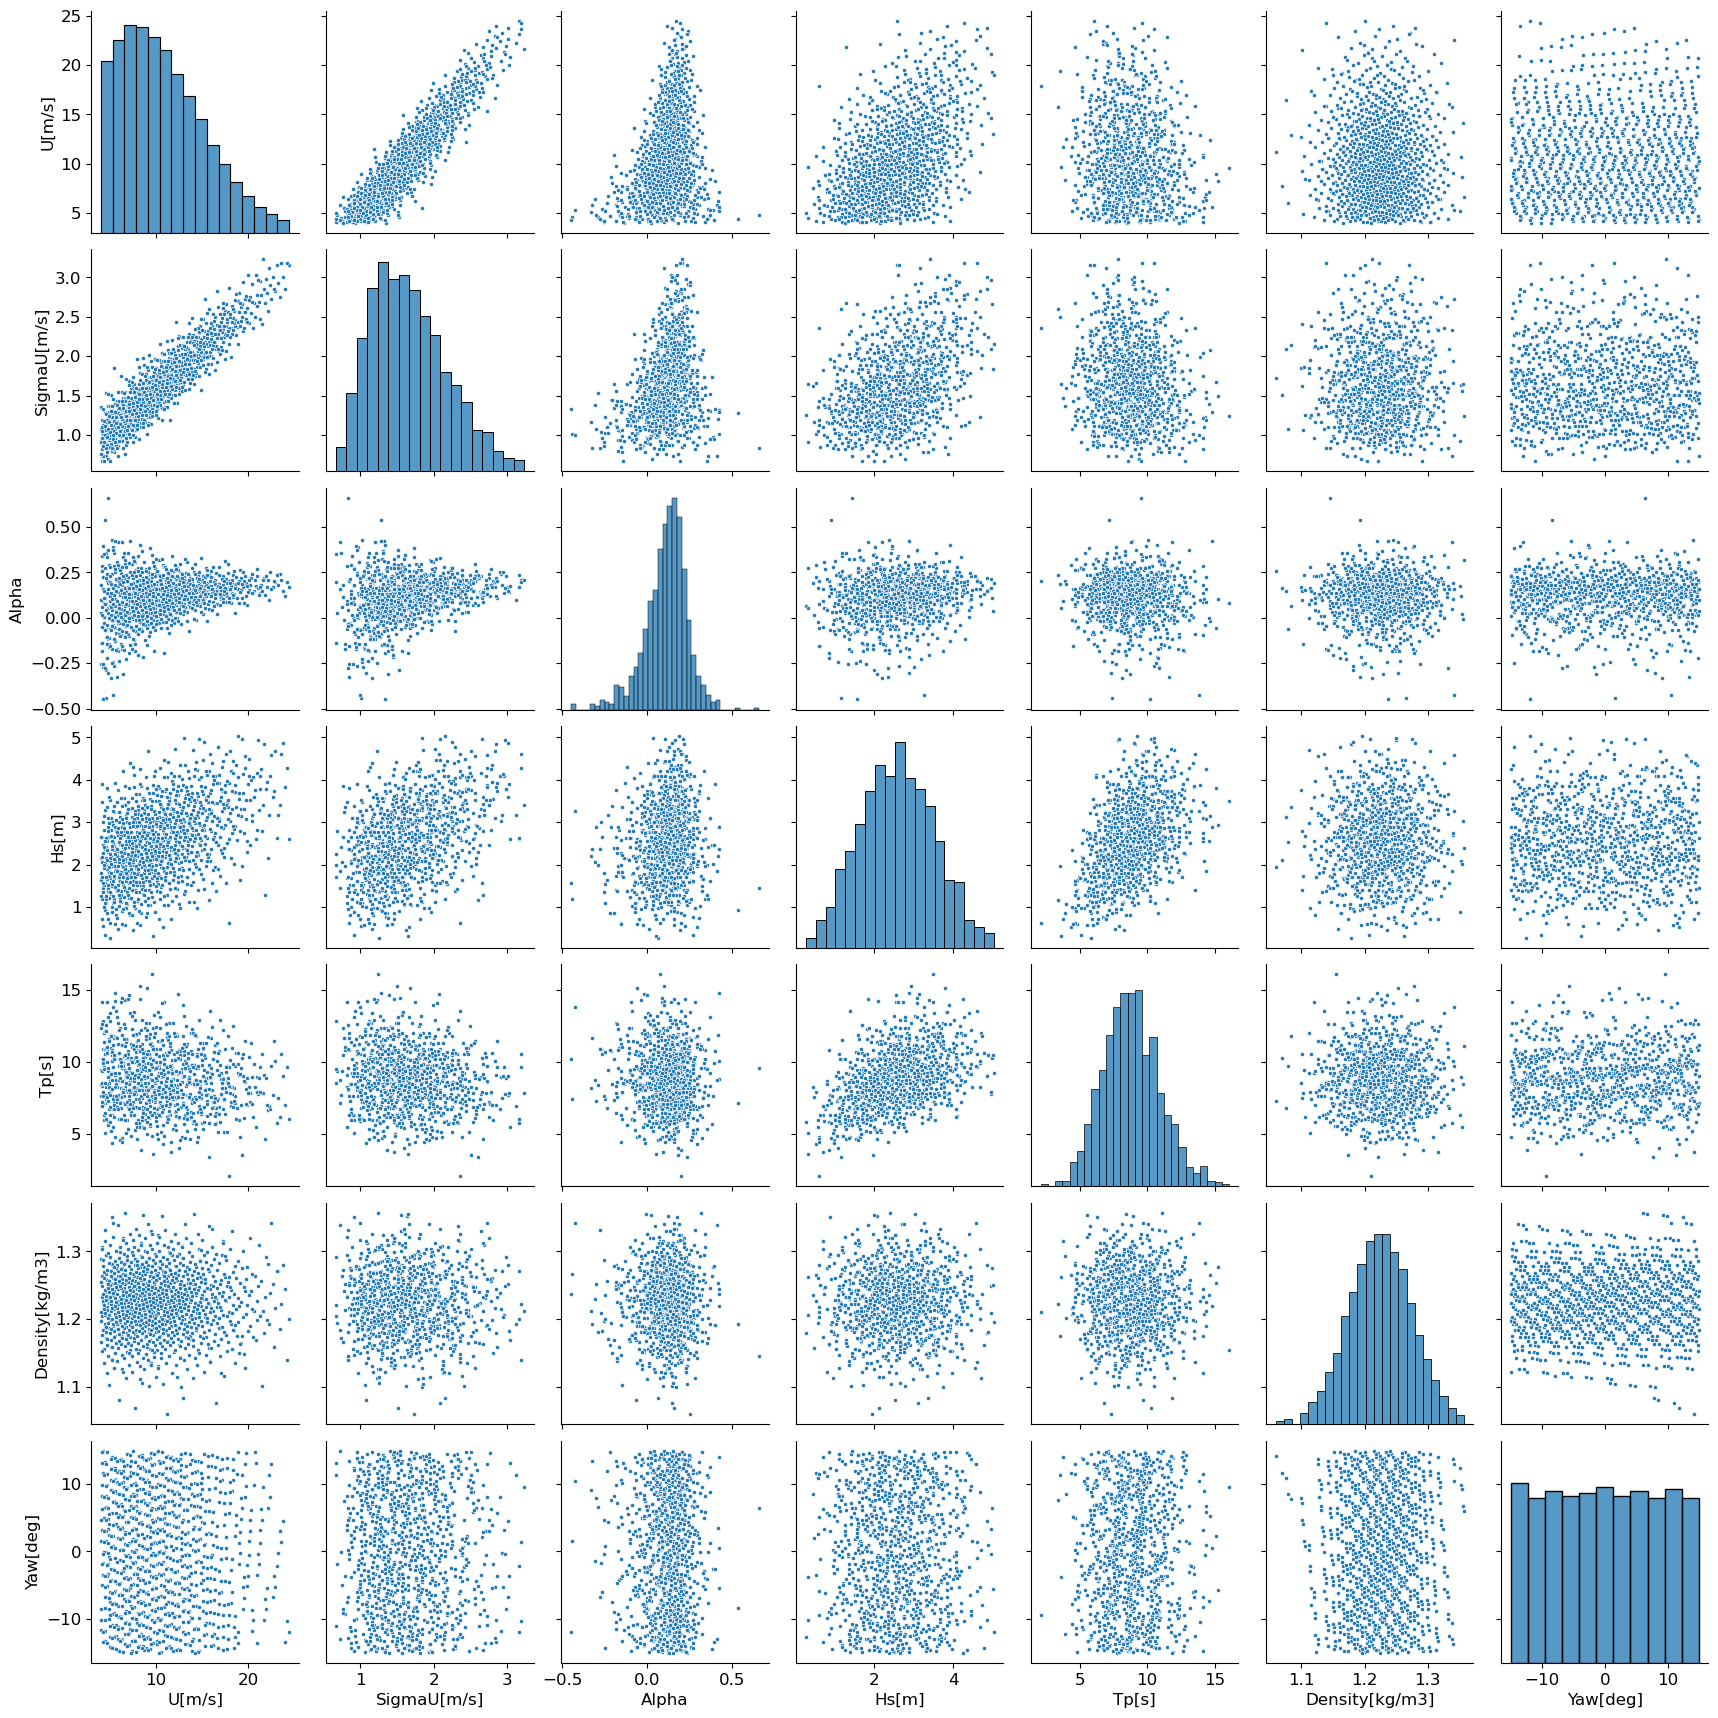

In [8]:
plt.rc('font', size = 12)
fig2 = sns.pairplot(data = pd.DataFrame(data = { 'U[m/s]': u, 'SigmaU[m/s]': SigmaU, 'Alpha': Alpha, 'Hs[m]': Hs, 'Tp[s]': Tp, 'Density[kg/m3]': Rho, 'Yaw[deg]' : Yaw}), markers = '.')
fig2.savefig('DoE_7D_pairplot.png')

In [9]:
Data = pd.DataFrame(data = {'PointNo': np.arange(1,Nsamples+1,dtype = 'int64'), 'U[m/s]': u, 'SigmaU[m/s]': SigmaU, 'Alpha': Alpha, 'Hs[m]': Hs, 'Tp[s]': Tp,'Density[kg/m3]': Rho, 'Yaw[deg]' : Yaw})

In [10]:
# Constant and derived values
Data['MannL'] = 29.4
Data['MannGamma'] = 3.9
#Data['AirDensity'] = 1.225
#Data['Hs'] = 1
#Data['Tp'] = 10
Data['TI'] = Data['SigmaU[m/s]']/Data['U[m/s]']
Data['turb_dx'] = Data['U[m/s]']*700/8192

In [12]:
Data

,PointNo,U[m/s],SigmaU[m/s],Alpha,Hs[m],Tp[s],Density[kg/m3],Yaw[deg],MannL,MannGamma,TI,turb_dx
0,1,10.155676,1.505139,0.033115,1.616862,5.556742,1.153696,-13.235294,29.4,3.9,0.148207,0.867795
1,2,7.228474,1.362112,0.051018,1.749554,6.839777,1.173996,-11.470589,29.4,3.9,0.188437,0.617667
2,3,13.756610,1.743080,0.161110,2.731947,7.525855,1.188184,-9.705882,29.4,3.9,0.126709,1.175492
3,4,5.730511,1.090666,0.212498,2.235431,8.692331,1.199880,-7.941176,29.4,3.9,0.190326,0.489668
4,5,11.791608,1.914334,-0.019339,3.172059,9.188290,1.210331,-6.176470,29.4,3.9,0.162347,1.007584
...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,6.105367,1.059651,0.027809,1.777348,8.871717,1.248770,3.392023,29.4,3.9,0.173560,0.521699
996,997,12.227318,1.871806,0.152096,2.707430,9.375283,1.260262,5.156729,29.4,3.9,0.153084,1.044815
997,998,9.022113,1.861812,0.197094,2.698676,10.533988,1.274028,6.921434,29.4,3.9,0.206361,0.770932
998,999,17.495981,1.969963,0.313235,3.886222,10.908246,1.293137,8.686140,29.4,3.9,0.112595,1.495018


In [13]:
# GENERATE WAVE PROPERTIES FILES
WaveTemplateFile = open('d:\Hawc2\IEA_15MW_Monopile\wavedata\Wave_template.inp','rt')
WaveTemplate = WaveTemplateFile.readlines()
WaveTemplateFile.close()

In [69]:
Data['WaveFileNames'] = ' '

In [78]:
for i in range(Nsamples):
    Hsi = Hs[i]
    Tpi = Tp[i]
    WaveDesci = WaveTemplate.copy()
    WaveDesci[13] = '    jonswap ' + str(Hsi.round(4)) + ' ' + str(Tpi.round(4)) + ' 2.2 ; Jonswap: Hs, Tp, gamma\n'
    WaveFilenamei = 'WaveInputSample_' + str(i+1) + '.inp'
    WavePathnamei = 'd:/Hawc2/IEA_15MW_Monopile/wavedata/' + WaveFilenamei
    WaveFilei = open(WaveFilenamei,'w')
    WaveFilei.writelines(WaveDesci)
    WaveFilei.close()
    Data.loc[i,'WaveFileNames'] = WaveFilenamei
    

In [80]:
Data.to_excel('Hawc2SimulationConditionsList_VS_Benchmark_Example.xlsx')

## Generate turbulence boxes based on the conditions in the data sheet

In [40]:
def GenerateBox(SamplePointRange, SampleData, SeedRange = None):
    from hipersim.turbgen import turbgen
    
    Nboxes = len(SamplePointRange)
    if SeedRange is None:
        SeedRange = np.arange(1,Nboxes+1,1,dtype = 'int')
                

    T = turbgen.turb_field(dy = 8.0, dz = 8.0, BaseName = 'turb', SaveToFile = 0, alphaepsilon = 0.1)
    for i in (range(len(SeedRange))):
        iseed = SeedRange[i]
        isample = SamplePointRange[i]
        print('Seed no. ' + str(iseed))
        T.params['dx'] = SampleData['turb_dx'][isample]
        T.params['SeedNo'] = iseed
        T.params['SaveToFile'] = 0
        T.TurbOptions = {'FileFormat': 0,
                         'zHub': 150,
                         'Umean': SampleData['U[m/s]'][isample],
                         'alpha': SampleData['Alpha'][isample],
                         'TI_u': (SampleData['SigmaU[m/s]'][isample])/(SampleData['U[m/s]'][isample]),
                         'TI_v': 0.8*(SampleData['SigmaU[m/s]'][isample])/(SampleData['U[m/s]'][isample]),
                         'TI_w': 0.5*(SampleData['SigmaU[m/s]'][isample])/(SampleData['U[m/s]'][isample]),
                         'Yaw': SampleData['Yaw[deg]'][isample]}
        T.generate()
        T.params['SaveToFile'] = 1
        T.output()
        

In [41]:
# How many turbulence boxes to generate?
Nboxes = 10
Seedrange = np.arange(1,Nboxes+1,1,dtype = 'int')
SamplePointRange = np.arange(0,Nboxes,dtype = 'int')
T = GenerateBox(SamplePointRange,Data,Seedrange)

Seed no. 1
Generating turbulence boxes..
Turbulence box generation complete.
Time elapsed is 55.81088137626648
Seed no. 2
Generating turbulence boxes..
Turbulence box generation complete.
Time elapsed is 50.56161713600159
Seed no. 3
Generating turbulence boxes..
Turbulence box generation complete.
Time elapsed is 61.179426193237305
Seed no. 4
Generating turbulence boxes..
Turbulence box generation complete.
Time elapsed is 45.87676525115967
Seed no. 5
Generating turbulence boxes..
Turbulence box generation complete.
Time elapsed is 41.22618293762207
Seed no. 6
Generating turbulence boxes..
Turbulence box generation complete.
Time elapsed is 45.44298815727234
Seed no. 7
Generating turbulence boxes..
Turbulence box generation complete.
Time elapsed is 41.24004101753235
Seed no. 8
Generating turbulence boxes..
Turbulence box generation complete.
Time elapsed is 35.24598002433777
Seed no. 9
Generating turbulence boxes..
Turbulence box generation complete.
Time elapsed is 39.3734815120697
S

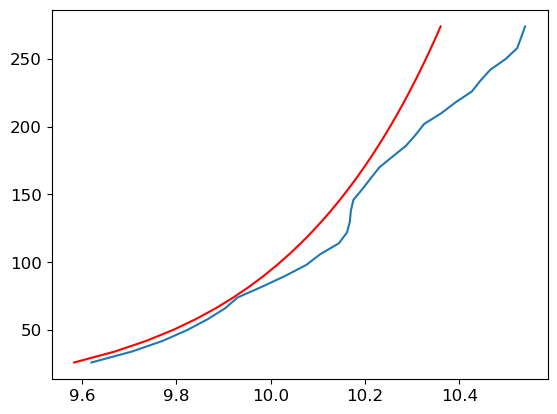

In [82]:
# CHECK WIND PROFILE IN TURBULENCE BOXES
Tu = np.fromfile('turb_1_u.bin',dtype = 'single').reshape((8192,32,32))
Tv = np.fromfile('turb_1_v.bin',dtype = 'single').reshape((8192,32,32))
z1 = 150 - 8*(32-1)/2
zbox = np.arange(32)*8 + z1

plt.plot(np.sqrt(Tu**2 + Tv**2).mean(axis=0).mean(axis=0), zbox)
plt.plot(Data['U[m/s]'][0]*(zbox/150)**Data['Alpha'][0], zbox,'-r')
plt.show()